## Setup

In [1]:
%matplotlib inline

In [2]:
!pip install aif360
!pip install adversarial-robustness-toolbox
!pip install shap
!pip install BlackBoxAuditing
# preventing future warnings
!pip install 'aif360[Reductions]'
!pip install 'aif360[inFairness]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 39.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394754 sha256=e5d4972ac3a204bc989ac0aa5963e1d5a03cb128136e82c9ea4e0919351d5656
  Stored in directory: /root/.cache/pip/wheels/c0/4f/b1/80e1b0790df07536470758fe0a4f9ff8fa942fd9fe30bbb192
Successfully built BlackBoxAuditing
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 34.8 MB/s eta 0:00:00


In [3]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [4]:
from aif360.datasets import StandardDataset
# StandardDataset??

In [5]:
from google.colab import drive
drive.mount('/content/drive')#, force_remount=True)

Mounted at /content/drive


In [6]:
%cd "/content/drive/MyDrive/Senior Design Project/mia-privacy-fairness-law-race"

/content/drive/MyDrive/Senior Design Project/mia-privacy-fairness-law-race


In [7]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from metrics_utils import get_orig_model_metrics
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias

/usr/local/lib/python3.10/dist-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/usr/local/lib/python3.10/dist-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_discounted

## Arguments & Initializations

In [8]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [9]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [135]:
DATASET = "law_race"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [136]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [137]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False
else:
    SCALER = False
DISPLAY = False
THRESH_ARR = 0.5

# loop ten times
N = 3

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list)
transf_mia_metrics = defaultdict(list)

reweigh_metrics = defaultdict(list)
reweigh_mia_metrics = defaultdict(list)

dir_metrics = defaultdict(list)
dir_mia_metrics = defaultdict(list)

egr_metrics = defaultdict(list)
egr_mia_metrics = defaultdict(list)


pr_orig_metrics = defaultdict(list)
cpp_metrics = defaultdict(list)
ro_metrics = defaultdict(list)

## Loading & Splitting Dataset

In [138]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

Categorical Variables []
Categorical Variables []


In [139]:
dataset_orig.features.shape

(20798, 13)

In [201]:
# Assuming dataset_orig is your BinaryLabelDataset object
race_labels = dataset_orig.labels.flatten()

# Count the number of race = 1 and race = 0
pd.Series(race_labels).value_counts()

,count
1.0,19758
0.0,1040


In [140]:
privileged_groups

[{'race': 1}]

In [141]:
unprivileged_groups

[{'race': 0}]

In [142]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[2. 2. 1. ... 4. 6. 8.]
 [3. 2. 0. ... 3. 2. 2.]
 [8. 8. 1. ... 6. 6. 8.]
 ...
 [9. 8. 1. ... 5. 6. 8.]
 [6. 6. 1. ... 3. 5. 5.]
 [5. 9. 1. ... 3. 5. 5.]]


In [143]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [144]:
dataset_orig_train

               instance weights features features            features  \
                                                  protected attribute   
                                 decile3  decile1                race   
instance names                                                          
85                          1.0      2.0      2.0                 1.0   
14508                       1.0      3.0      2.0                 0.0   
12515                       1.0      8.0      8.0                 1.0   
7320                        1.0      1.0      1.0                 1.0   
8399                        1.0      2.0      2.0                 1.0   
...                         ...      ...      ...                 ...   
12585                       1.0      6.0      7.0                 1.0   
12960                       1.0      2.0      3.0                 1.0   
3621                        1.0      9.0      8.0                 1.0   
6123                        1.0      6.0      6.0  

In [145]:
dataset_orig_train?

## Run Mitigating Algorithms

In [146]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False))
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True)
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False)
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER)

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)

    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER)

    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER)

#### Train dataset's features are as below:
[[ 9.  9.  1. ...  2.  6.  6.]
 [ 1.  1.  0. ...  6.  4.  4.]
 [ 9. 10.  1. ...  4.  6.  8.]
 ...
 [ 2.  4.  0. ...  2.  6.  7.]
 [ 6.  8.  1. ...  4.  6.  8.]
 [ 1.  1.  0. ...  4.  2.  2.]]
no bias type specified
#### Training Dataset shape
(10399, 13)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['decile3', 'decile1', 'race', 'cluster', 'lsat', 'ugpa', 'dob_yr', 'fulltime', 'fam_inc', 'gender', 'tier', 'indxgrp', 'indxgrp2']
privileged vs. unprivileged:  8724.0 1675.0
base_pos unpriv:  0.8340298507462687
base_pos priv:  0.9658413571756075
number of favorable labels:  9823
Difference in mean outcomes between unprivileged and privileged groups = -0.131812
#### Train shape, validation shape, test shape
(10399, 13

/usr/local/lib/python3.10/dist-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/usr/local/lib/python3.10/dist-packages/fairlearn/reductions/_moments

y_val_pred_prob:  [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Accuracy for threshold: 0.01  is: 0.9523031060678911
Balanced accuracy is:  0.5302345634555646
Accuracy for threshold: 0.02  is: 0.9523031060678911
Balanced accuracy is:  0.5302345634555646
Accuracy for threshold: 0.03  is: 0.9523031060678911
Balanced accuracy is:  0.5302345634555646
Accuracy for threshold: 0.04  is: 0.9523031060678911
Balanced accuracy is:  0.5302345634555646
Accuracy for threshold: 0.05  is: 0.9523031060678911
Balanced accuracy is:  0.5302345634555646
Accuracy for threshold: 0.060000000000000005  is: 0.9523031060678911
Balanced accuracy is:  0.5302345634555646
Accuracy for threshold: 0.06999999999999999  is: 0.9523031060678911
Balanced accuracy is:  0.5302345634555646
Accuracy for threshold: 0.08  is: 0.9523031060678911
Balanced accuracy is:  0.5302345634555646
Accuracy for threshold: 0.09  is: 0.9523031060678911
Balanced accuracy is:  0.5302345634555646
Accuracy for threshold: 0.09999999999999999  is: 0.952

/usr/local/lib/python3.10/dist-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/usr/local/lib/python3.10/dist-packages/fairlearn/reductions/_moments

y_val_pred_prob:  [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Accuracy for threshold: 0.01  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.02  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.03  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.04  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.05  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.060000000000000005  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.06999999999999999  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.08  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.09  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.09999999999999999  is: 0.948

/usr/local/lib/python3.10/dist-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/usr/local/lib/python3.10/dist-packages/fairlearn/reductions/_moments

y_val_pred_prob:  [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
Accuracy for threshold: 0.01  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.02  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.03  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.04  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.05  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.060000000000000005  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.06999999999999999  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.08  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.09  is: 0.9489373978267142
Balanced accuracy is:  0.5333419584842735
Accuracy for threshold: 0.09999999999999999  is: 0.948

## Display Output

In [147]:
priv_metric_orig_copy = priv_metric_orig

In [148]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 26218.0, 'total_unpriv': 4979.0})

In [149]:
priv_metric_orig

defaultdict(float, {'total_priv': 26218.0, 'total_unpriv': 4979.0})

In [150]:
priv_metric_orig = priv_metric_orig_copy

1)

law_race
10399
2)

               total_priv  total_unpriv
num_instance                           
orig          8739.333333   1659.666667
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.947559       0.052441    0.966663      0.033337      0.847017   
transf      0.966662       0.033338    0.966663      0.033337      0.966660   

         unpriv_unfavor  
dataset                  
orig           0.152983  
transf         0.033340  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.588934      -0.136456  0.097923      -0.096284   
dt_syn                     0.550984      -0.047519  0.053043      -0.052287   
dt_dir                     0.584852      -0.117439  0.086350      -0.084656   
dt_rew                     0.5643

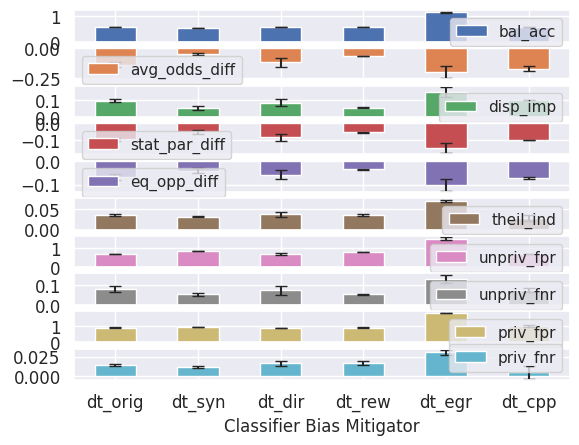

In [151]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

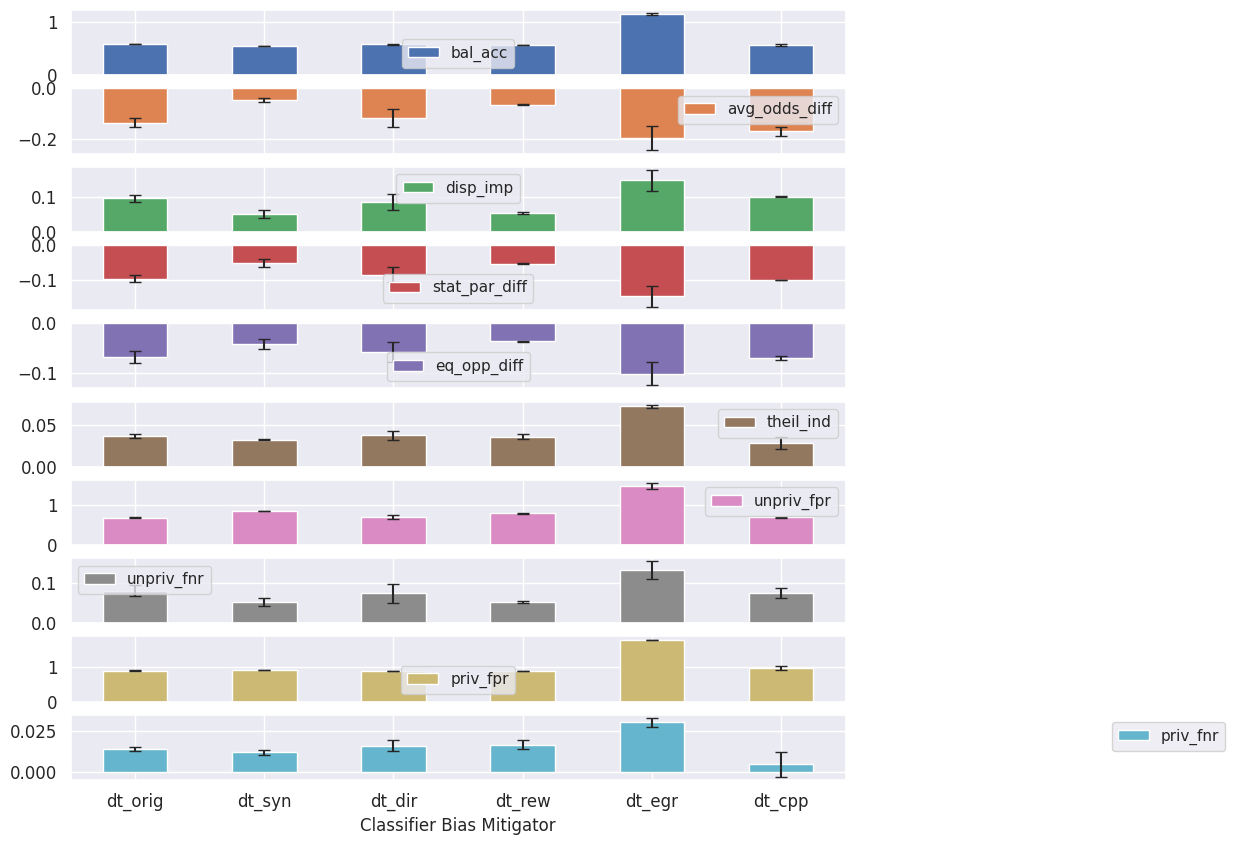

In [152]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [153]:
df

,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind,unpriv_fpr,unpriv_fnr,priv_fpr,priv_fnr
Classifier Bias Mitigator,,,,,,,,,,
dt_orig,0.588934,-0.136456,0.097923,-0.096284,-0.067307,0.036325,0.686607,0.081097,0.892213,0.013791
dt_syn,0.550984,-0.047519,0.053043,-0.052287,-0.041874,0.032087,0.851305,0.053739,0.904468,0.011865
dt_dir,0.584852,-0.117439,0.086350,-0.084656,-0.058194,0.037420,0.709169,0.074261,0.885852,0.016066
dt_rew,0.564350,-0.065115,0.055171,-0.054089,-0.036500,0.035652,0.798389,0.053243,0.892119,0.016743
dt_egr,1.151167,-0.198202,0.149989,-0.147399,-0.101615,0.071592,1.491902,0.131988,1.786690,0.030373
dt_cpp,0.571109,-0.170497,0.101679,-0.101126,-0.070733,0.028417,0.696661,0.075240,0.966921,0.004507


## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [154]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [155]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.517982,0.700114,0.512874,0.695316,0.542301,0.712650,0.508645
syn,0.514216,0.647777,0.511634,0.629731,0.527026,0.676196,0.509410
dir,0.527423,0.656315,0.524763,0.656117,0.550892,0.678711,0.522651
rew,0.516572,0.676718,0.511764,0.632036,0.533419,0.720466,0.508336
egr,0.517646,0.698248,0.512336,0.692040,0.541729,0.711967,0.508114


In [156]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [157]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [158]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.695316,0.542301,0.712650,0.508645
syn,0.629731,0.527026,0.676196,0.509410
dir,0.656117,0.550892,0.678711,0.522651
rew,0.632036,0.533419,0.720466,0.508336
egr,0.692040,0.541729,0.711967,0.508114


<Axes: xlabel='Classifier MIA Attacks'>

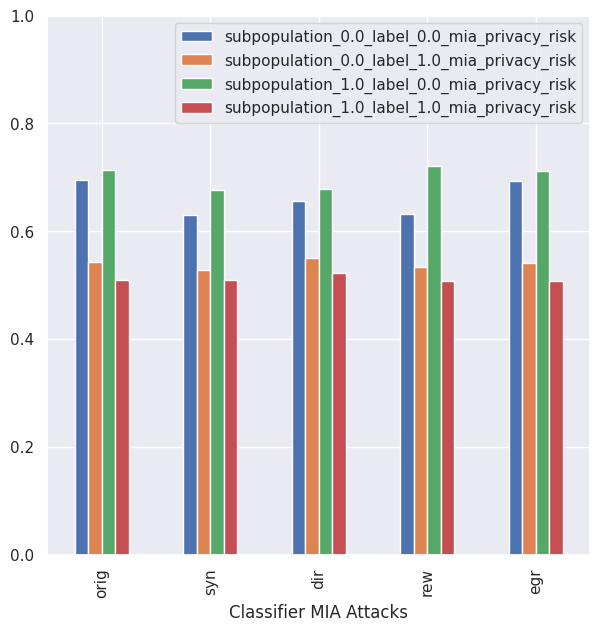

In [159]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [160]:
# Tabular Format
# importing the modules
from tabulate import tabulate


# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew       egr
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.695316  0.629731  0.656117  0.632036  0.69204
subpopulation_0.0_label_1.0_mia_privacy_risk  0.542301  0.527026  0.550892  0.533419  0.541729
subpopulation_1.0_label_0.0_mia_privacy_risk  0.71265   0.676196  0.678711  0.720466  0.711967
subpopulation_1.0_label_1.0_mia_privacy_risk  0.508645  0.50941   0.522651  0.508336  0.508114


### Visualizing using novel technique

In [161]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [162]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [163]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517982
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517982
3,orig,entire_dataset_label_0.0_mia_privacy_risk,0.697198
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.701572
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.727737
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.727737
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.510690
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.506826


In [164]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517982
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517982
9,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.705713
10,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.690117
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.727737
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.727737
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.510690
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.506826


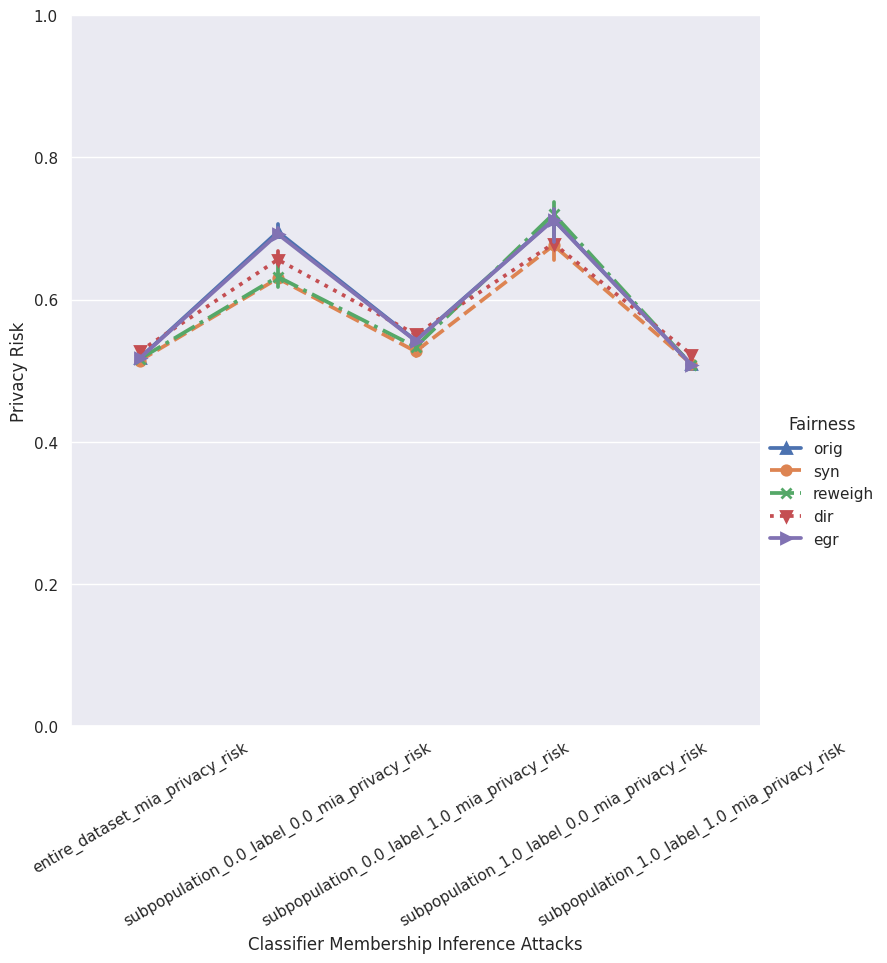

In [165]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [166]:
from sklearn.metrics import RocCurveDisplay, auc

In [167]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

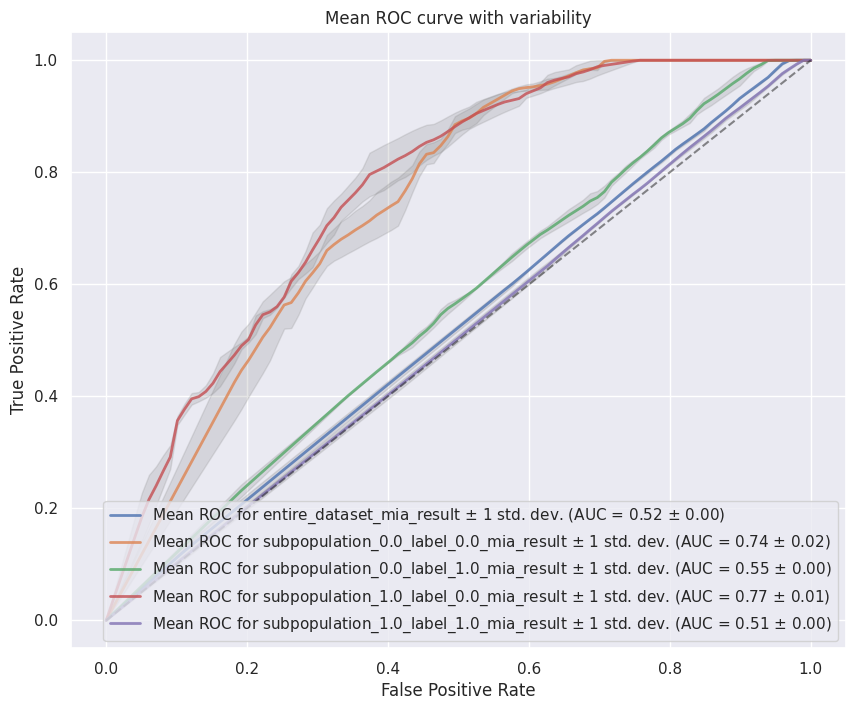

In [168]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []

    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)

    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())

    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

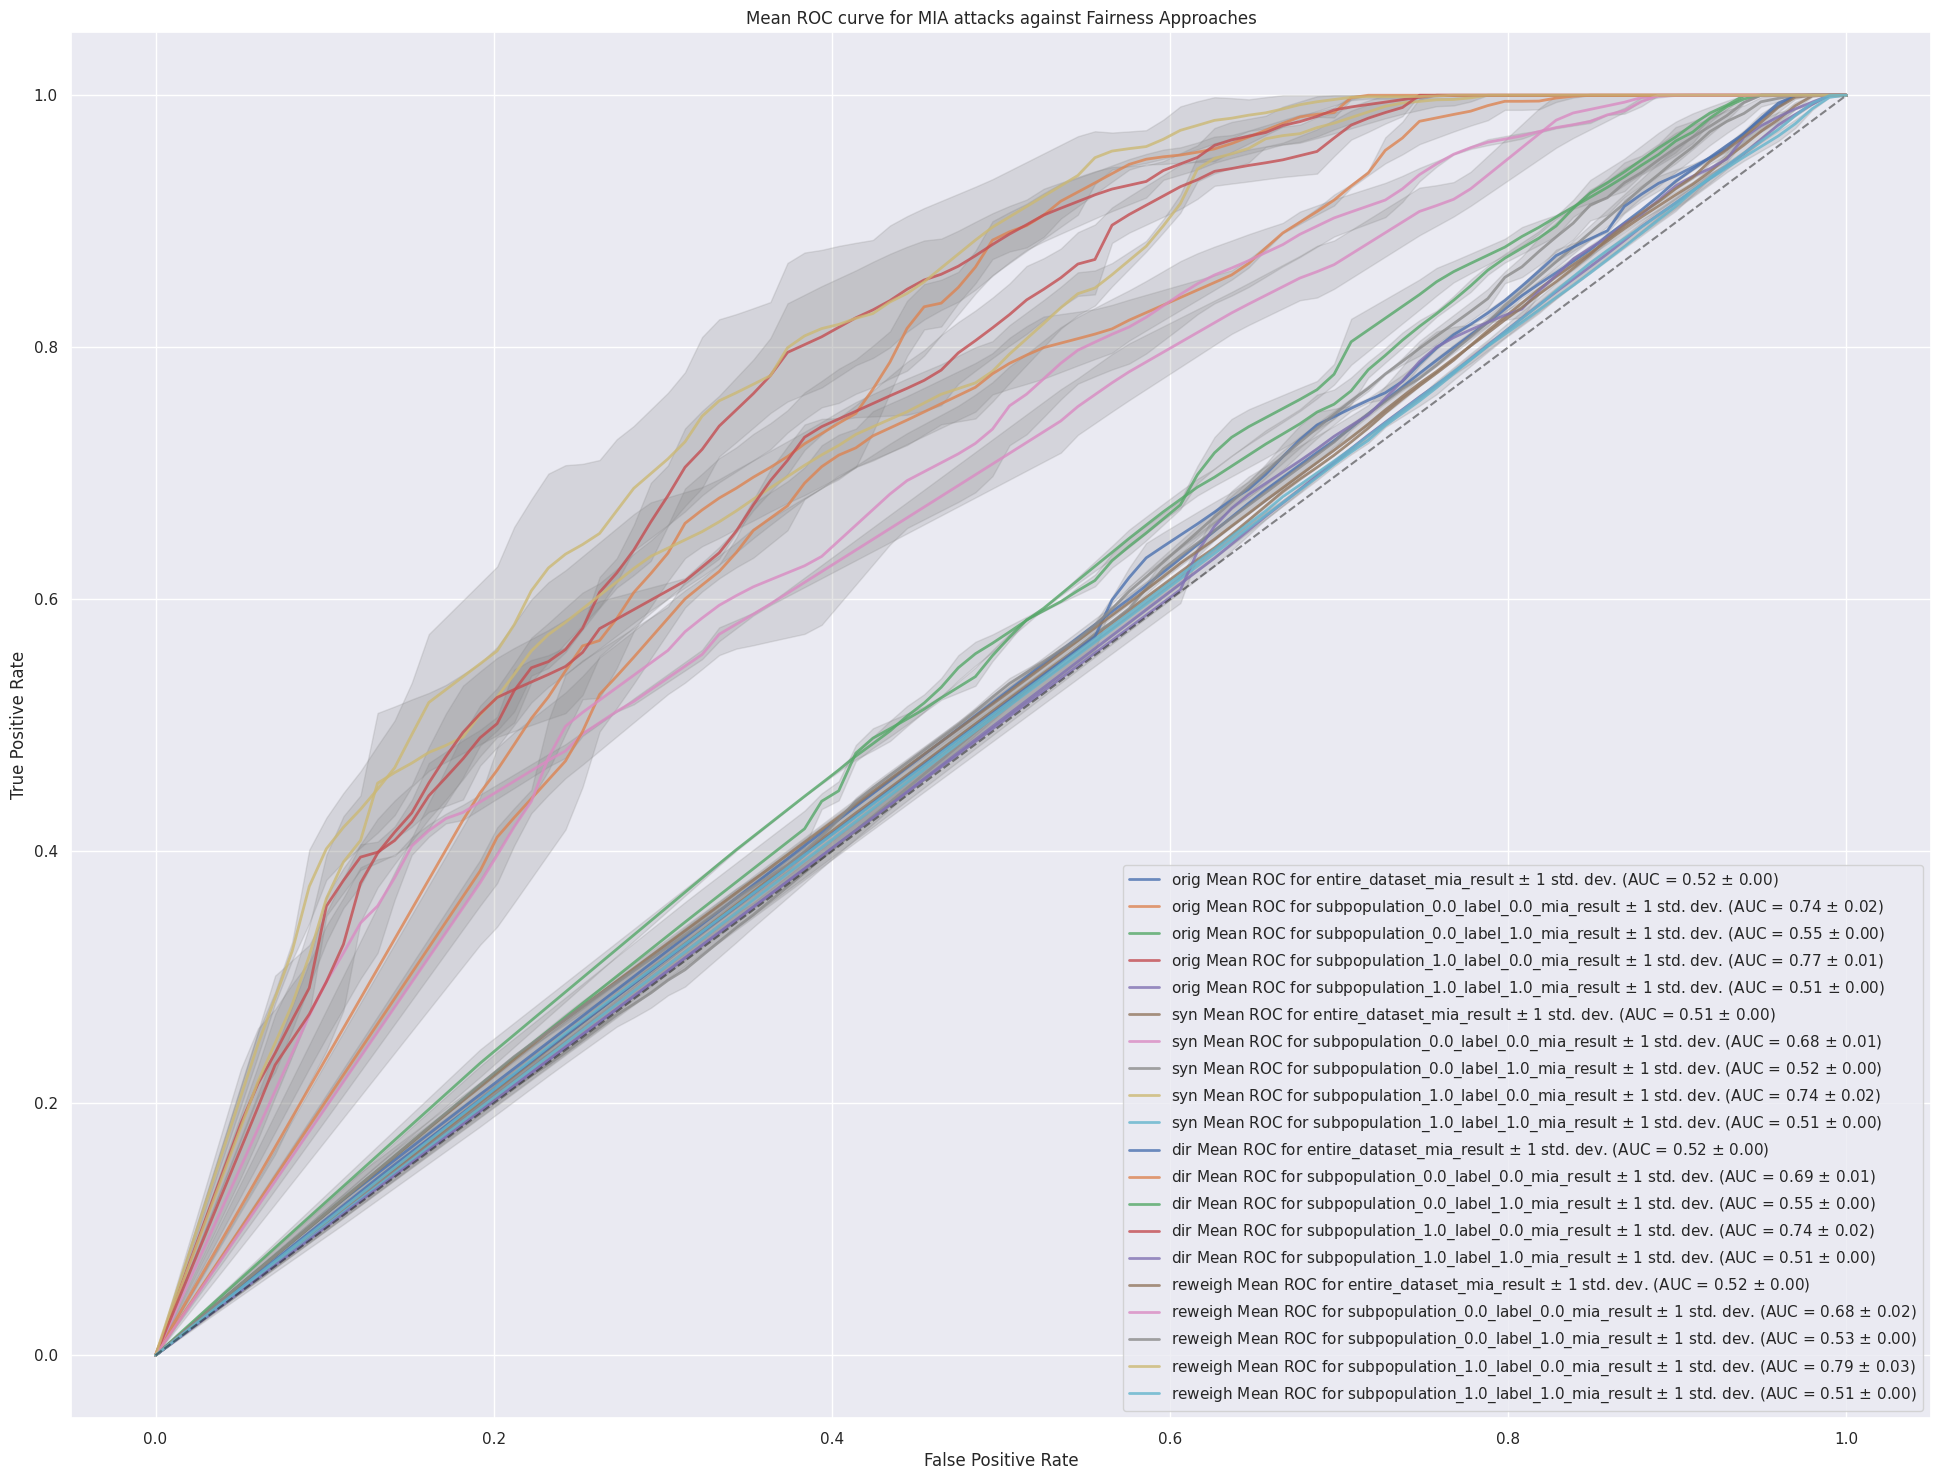

In [169]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:

        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

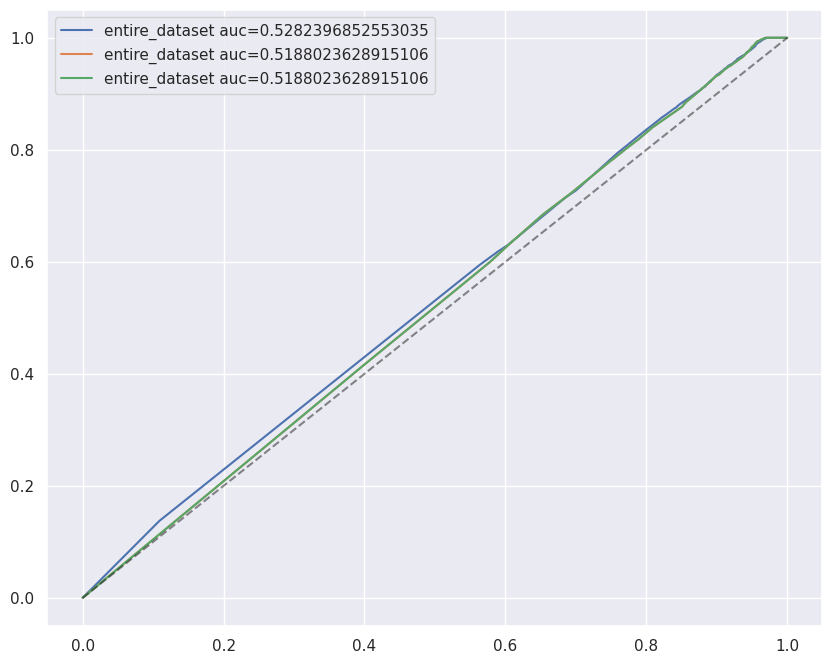

In [170]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart

In [171]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}

In [172]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5219481370127749,
 'entire_dataset_label_0.0_mia_auc': 0.750807903863603,
 'entire_dataset_label_1.0_mia_auc': 0.513554516859193,
 'subpopulation_0.0_label_0.0_mia_auc': 0.7415076125174389,
 'subpopulation_0.0_label_1.0_mia_auc': 0.5530148600710417,
 'subpopulation_1.0_label_0.0_mia_auc': 0.7667205261117988,
 'subpopulation_1.0_label_1.0_mia_auc': 0.5067097995615701}

In [173]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.521948,0.750808,0.513555,0.741508,0.553015,0.766721,0.506710
syn,0.514984,0.714759,0.509466,0.676173,0.516104,0.744514,0.508608
dir,0.522948,0.712189,0.516686,0.693599,0.549685,0.739906,0.512256
rew,0.520923,0.738566,0.513634,0.676809,0.531333,0.787073,0.511344


<Axes: xlabel='Classifier MIA Attacks'>

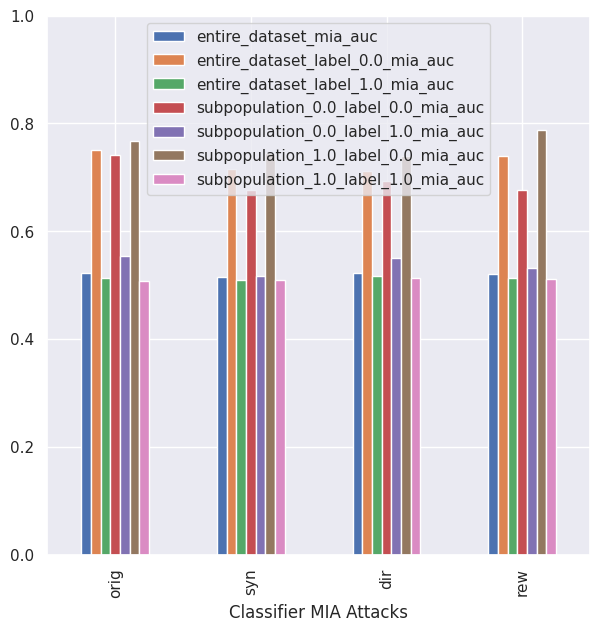

In [174]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [175]:
# Creating data structures to plot point categorical plot from seaborn

In [176]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}

In [177]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.03596499663429176,
  0.03596499663429176,
  0.03596499663429176],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.39439655172413796,
  0.40314465408805034,
  0.40314465408805034],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.030492018746918648,
  0.023377209182222636,
  0.023377209182222636],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.4114253151933899,
  0.38023473852350853,
  0.38023473852350853],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.08877264467815649,
  0.082517255013839,
  0.082517255013839],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.37230390901173216,
  0.451797385620915,
  0.451797385620915],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.021491693148206092,
  0.015187809197081403,
  0.015187809197081403]}

In [178]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.03596499663429176],
 ['orig', 'entire_dataset', 0.03596499663429176],
 ['orig', 'entire_dataset', 0.03596499663429176],
 ['orig', 'entire_dataset_label_0.0', 0.39439655172413796],
 ['orig', 'entire_dataset_label_0.0', 0.40314465408805034],
 ['orig', 'entire_dataset_label_0.0', 0.40314465408805034],
 ['orig', 'entire_dataset_label_1.0', 0.030492018746918648],
 ['orig', 'entire_dataset_label_1.0', 0.023377209182222636],
 ['orig', 'entire_dataset_label_1.0', 0.023377209182222636],
 ['orig', 'subpopulation_0.0_label_0.0', 0.4114253151933899],
 ['orig', 'subpopulation_0.0_label_0.0', 0.38023473852350853],
 ['orig', 'subpopulation_0.0_label_0.0', 0.38023473852350853],
 ['orig', 'subpopulation_0.0_label_1.0', 0.08877264467815649],
 ['orig', 'subpopulation_0.0_label_1.0', 0.082517255013839],
 ['orig', 'subpopulation_0.0_label_1.0', 0.082517255013839],
 ['orig', 'subpopulation_1.0_label_0.0', 0.37230390901173216],
 ['orig', 'subpopulation_1.0_label_0.0', 0.45179738

In [179]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.035965
1,orig,entire_dataset,0.035965
2,orig,entire_dataset,0.035965
3,orig,entire_dataset_label_0.0,0.394397
4,orig,entire_dataset_label_0.0,0.403145
...,...,...,...
79,dir,subpopulation_1.0_label_0.0,0.353554
80,dir,subpopulation_1.0_label_0.0,0.353554
81,dir,subpopulation_1.0_label_1.0,0.033085
82,dir,subpopulation_1.0_label_1.0,0.051410


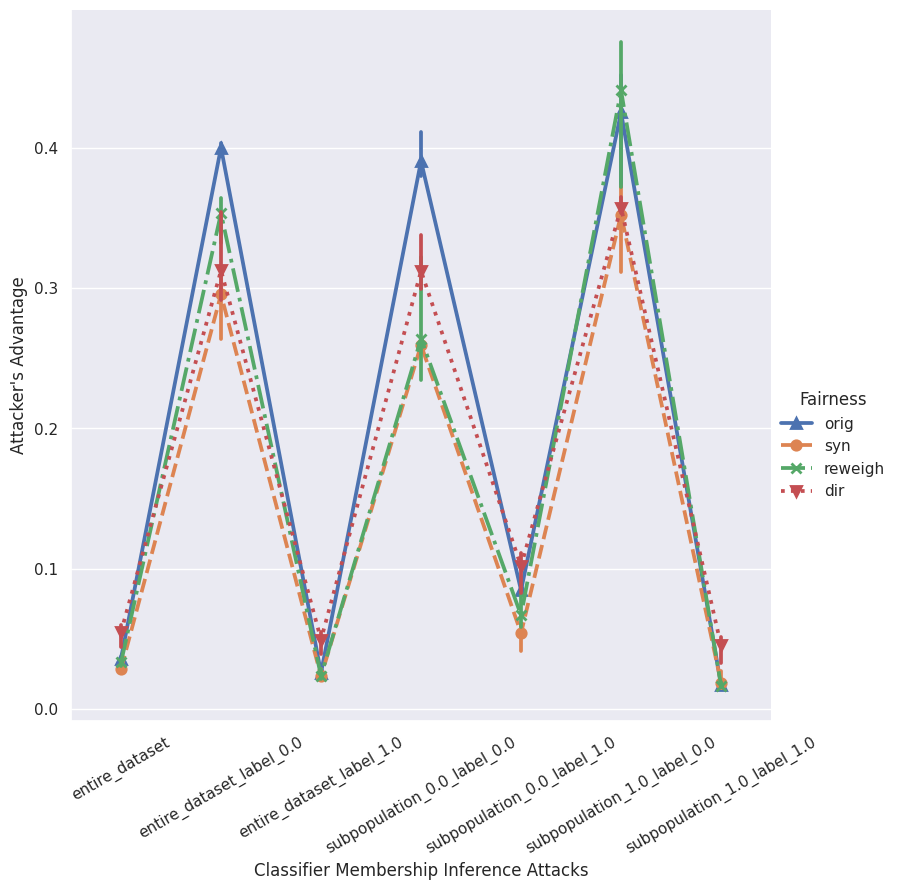

In [180]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


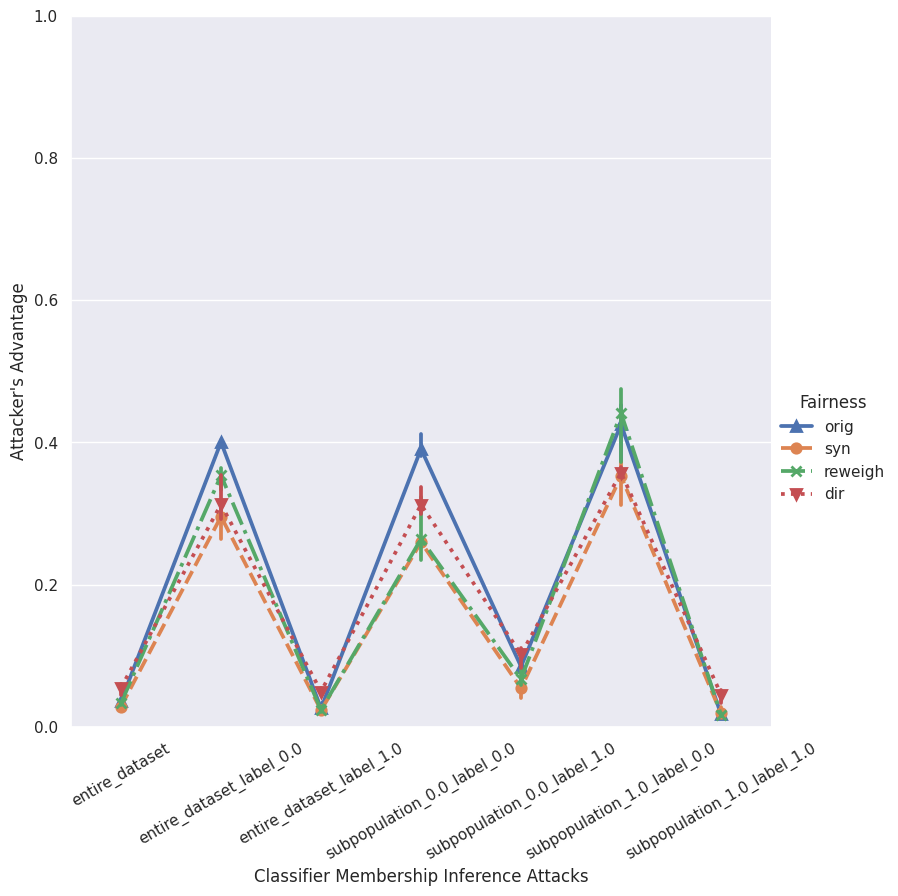

In [181]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [182]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.035965,0.394397,0.030492,0.411425,0.088773,0.372304,0.021492
1,0.035965,0.403145,0.023377,0.380235,0.082517,0.451797,0.015188
2,0.035965,0.403145,0.023377,0.380235,0.082517,0.451797,0.015188


In [183]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}


In [184]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.03596499663429176,
 'entire_dataset_label_0.0_mia_attacker_advantage': 0.4002286199667462,
 'entire_dataset_label_1.0_mia_attacker_advantage': 0.02574881237045464,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.39063159741346903,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.08460238490194483,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.4252995600845207,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.0172891038474563}

In [185]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.035965,0.400229,0.025749,0.390632,0.084602,0.425300,0.017289
syn,0.028432,0.295555,0.023268,0.259462,0.054052,0.352392,0.018820
dir,0.054845,0.312629,0.049526,0.312235,0.101785,0.357422,0.045302
rew,0.033144,0.353436,0.023528,0.264072,0.066839,0.440933,0.016672


<Axes: xlabel='Classifier MIA Attacks'>

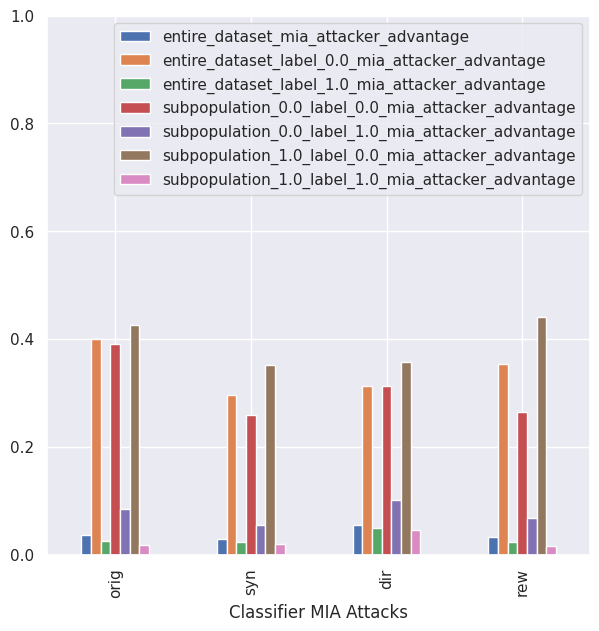

In [186]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [187]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}

In [188]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5578125],
 ['orig', 'entire_dataset', 0.5116629584439819],
 ['orig', 'entire_dataset', 0.5116629584439819],
 ['orig', 'entire_dataset_label_0.0', 0.8134328358208954],
 ['orig', 'entire_dataset_label_0.0', 0.7237237237237237],
 ['orig', 'entire_dataset_label_0.0', 0.7237237237237237],
 ['orig', 'entire_dataset_label_1.0', 0.5279232111692844],
 ['orig', 'entire_dataset_label_1.0', 0.5074036065093095],
 ['orig', 'entire_dataset_label_1.0', 0.5074036065093095],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7978142076502732],
 ['orig', 'subpopulation_0.0_label_0.0', 0.6825396825396826],
 ['orig', 'subpopulation_0.0_label_0.0', 0.6825396825396826],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5571658615136876],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5384615384615383],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5384615384615383],
 ['orig', 'subpopulation_1.0_label_0.0', 0.8470588235294118],
 ['orig', 'subpopulation_1.0_label_0.0', 0.7938931297709924],
 ['orig', 's

In [189]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.557813
1,orig,entire_dataset,0.511663
2,orig,entire_dataset,0.511663
3,orig,entire_dataset_label_0.0,0.813433
4,orig,entire_dataset_label_0.0,0.723724
...,...,...,...
79,dir,subpopulation_1.0_label_0.0,0.755725
80,dir,subpopulation_1.0_label_0.0,0.755725
81,dir,subpopulation_1.0_label_1.0,0.510213
82,dir,subpopulation_1.0_label_1.0,0.517613


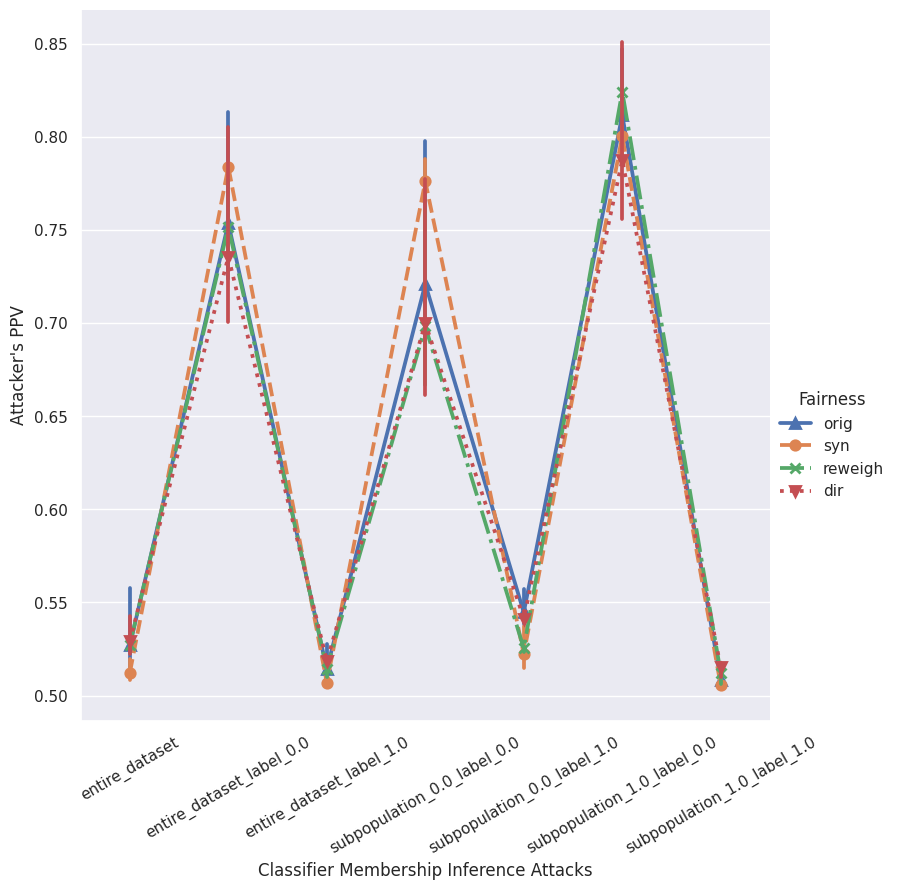

In [190]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [191]:
import pandas as pd

In [192]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,decile3,decile1,race,cluster,lsat,ugpa,dob_yr,fulltime,fam_inc,gender,tier,indxgrp,indxgrp2,labels
0,10.0,10.0,1.0,1.0,44.0,3.5,69.0,1.0,5.0,0.0,4.0,6.0,8.0,1.0
1,4.0,5.0,1.0,2.0,29.0,3.5,69.0,1.0,4.0,0.0,2.0,5.0,5.0,1.0
2,7.0,8.0,1.0,1.0,37.0,3.4,68.0,1.0,3.0,1.0,4.0,6.0,7.0,1.0
3,7.0,8.0,1.0,1.0,43.0,3.3,67.0,1.0,4.0,0.0,4.0,6.0,8.0,1.0
4,2.0,3.0,1.0,4.0,41.0,3.3,64.0,1.0,4.0,0.0,5.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20793,8.0,9.0,1.0,5.0,42.0,3.0,67.0,1.0,4.0,1.0,6.0,6.0,7.0,1.0
20794,9.0,4.0,1.0,3.0,29.5,3.5,68.0,1.0,4.0,1.0,3.0,5.0,5.0,1.0
20795,1.0,1.0,0.0,3.0,33.0,3.1,69.0,1.0,3.0,1.0,3.0,5.0,5.0,0.0
20796,5.0,4.0,1.0,3.0,32.0,3.0,67.0,0.0,3.0,1.0,3.0,5.0,5.0,1.0


In [193]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER)

[INFO]: training decision tree
Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.61      0.76       242
         1.0       0.00      0.00      0.00         0

    accuracy                           0.61       242
   macro avg       0.50      0.31      0.38       242
weighted avg       1.00      0.61      0.76       242

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.99      0.99      1410

    accuracy                           0.99      1410
   macro avg       0.50      0.49      0.50      1410
weighted avg       1.00      0.99      0.99      1410

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.40      0.57       288
         1.0       0.00      0.00      0.00         0

    accuracy                           0.40      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

{'train_0_0': 0.6115702479338843,
 'train_0_1': 0.9893617021276596,
 'train_1_0': 0.3958333333333333,
 'train_1_1': 0.9982267407494976,
 'test_0_0': 0.31512605042016806,
 'test_0_1': 0.926605504587156,
 'test_1_0': 0.11397058823529412,
 'test_1_1': 0.9863078375826251}

In [194]:
df[["age", "labels"]].value_counts(normalize=True)

KeyError: "['age'] not in index"

In [ ]:
df.drop_duplicates()